### Notebook to think about pseudo populations
Technique detailed in Bernardi et al 2020, Geometry of Abstraction paper

In [26]:
# how do we design this: 
# firing rates: spike counts, trial_number, time_bin, unit, all associated with a session
# per session, can assume all units present
# per condition, per session, need to split trials into train/test sets

"""
ConditionChecker
    inputs: 
        - condition columns
        - beh data
        - num per condition
    outputs: 
        - checks whether all conditions have enough trials

ConditionSplitter
    inputs 
        - condition columns, 
        - beh data
    outputs: 
        - per iteration: map between condition -> train/test splits
  
NOTE: MAYBE don't need this, handled ish by normalization step in network..
zscore_spikes
    per neuron, per timepoint, across conditions, z-score 
    input: 
        - train trial_numbers, test trial_numbers
        - spikes df, with columns: spike_count, unit id, time_bin, trial_number
    output: 
        - z_scored spikes df, with columns: spike_z_score, 

PsuedoGenerator
    inputs: 
        - num_train_per_condition
        - num_test_per_condition
        - sessions ids:
        - type of condition splitter (ConditionBlockSplitter or ConditionSplitter), 
    - output, per train/test split:
        - train x: spike_count, unit_id, time_bin, p_trial_number
        - train y: condition, p_trial_number
        - test_x: spike_count, unit_id, time_bin, p_trial_number
        - test_y: condition, p_trial_number
""" 


"\nConditionChecker\n    inputs: \n        - condition columns\n        - beh data\n        - num per condition\n    outputs: \n        - checks whether all conditions have enough trials\n\nConditionSplitter\n    inputs \n        - condition columns, \n        - beh data\n    outputs: \n        - per iteration: map between condition -> train/test splits\n  \nNOTE: MAYBE don't need this, handled ish by normalization step in network..\nzscore_spikes\n    per neuron, per timepoint, across conditions, z-score \n    input: \n        - train trial_numbers, test trial_numbers\n        - spikes df, with columns: spike_count, unit id, time_bin, trial_number\n    output: \n        - z_scored spikes df, with columns: spike_z_score, \n\nPsuedoGenerator\n    inputs: \n        - num_train_per_condition\n        - num_test_per_condition\n        - sessions ids:\n        - type of condition splitter (ConditionBlockSplitter or ConditionSplitter), \n    - output, per train/test split:\n        - train x

In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.condition_block_splitter import RuleConditionBlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 20})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
torch.cuda.is_available()

True

In [29]:
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
behavior_data["PrevResponse"] = behavior_data.Response.shift()
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [30]:
behavior_data

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,Item1Shape,Item1Color,Item1Pattern,Item2Shape,Item2Color,Item2Pattern,Item3Shape,Item3Color,Item3Pattern,PrevResponse
0,0,0,0,NaN,5276,Correct,0.0,1,RIPPLE,NaN,...,STAR,GREEN,POLKADOT,CIRCLE,CYAN,ESCHER,SQUARE,MAGENTA,SWIRL,None
1,1,0,1,NaN,5628,Correct,0.0,1,RIPPLE,NaN,...,STAR,MAGENTA,POLKADOT,TRIANGLE,YELLOW,ESCHER,CIRCLE,GREEN,SWIRL,Correct
2,2,0,2,NaN,5752,Correct,0.0,1,RIPPLE,NaN,...,TRIANGLE,MAGENTA,POLKADOT,STAR,CYAN,ESCHER,CIRCLE,YELLOW,SWIRL,Correct
3,3,0,3,NaN,5691,Correct,0.0,1,RIPPLE,NaN,...,STAR,MAGENTA,POLKADOT,CIRCLE,GREEN,ESCHER,TRIANGLE,CYAN,SWIRL,Correct
4,4,0,4,NaN,5523,Correct,0.0,1,RIPPLE,NaN,...,CIRCLE,YELLOW,POLKADOT,SQUARE,GREEN,ESCHER,TRIANGLE,CYAN,SWIRL,Correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,1757,55,14,NaN,3873,NoFixation,NaN,6,YELLOW,GREEN,...,CIRCLE,CYAN,RIPPLE,TRIANGLE,MAGENTA,ESCHER,SQUARE,GREEN,POLKADOT,NoFixation
1758,1758,55,15,NaN,3806,Late,NaN,6,YELLOW,GREEN,...,TRIANGLE,CYAN,SWIRL,SQUARE,MAGENTA,POLKADOT,CIRCLE,GREEN,ESCHER,NoFixation
1759,1759,55,16,NaN,3515,NoFixation,NaN,6,YELLOW,GREEN,...,STAR,CYAN,POLKADOT,CIRCLE,MAGENTA,SWIRL,SQUARE,GREEN,ESCHER,Late
1760,1760,55,17,NaN,3472,NoFixation,NaN,6,YELLOW,GREEN,...,STAR,CYAN,ESCHER,SQUARE,MAGENTA,RIPPLE,CIRCLE,GREEN,SWIRL,NoFixation


### Filter out trials
- Rules where it occurs in at least 3 blocks
- last 5 correct trials of the blocks, where previous trial is correct as well

In [31]:
# get trials where correct and previous trial was correct as well, only 640 trials
cor_cors = valid_beh[(valid_beh.Response == "Correct") & (valid_beh.PrevResponse == "Correct")]

In [32]:
num_blocks = cor_cors.groupby(by="CurrentRule").apply(lambda g: len(g.BlockNumber.unique()))
valid_rules = num_blocks[num_blocks > 3].index

In [33]:
num_blocks

CurrentRule
CIRCLE      5
CYAN        6
ESCHER      1
GREEN       6
MAGENTA     3
POLKADOT    4
RIPPLE      4
SQUARE      5
STAR        2
SWIRL       4
TRIANGLE    7
YELLOW      5
dtype: int64

In [34]:
cor_cor_valid_rules = cor_cors[cor_cors.CurrentRule.isin(valid_rules)]

In [35]:
def last_five(block):
    # last 5 items that meet this critera
    return block.iloc[-5:]

last_fives = cor_cor_valid_rules.groupby(by="BlockNumber", as_index=False).apply(last_five).reset_index()

In [36]:
# test out splitter

splitter = RuleConditionBlockSplitter(last_fives)

In [37]:
split = next(splitter)

### Look at firing rates

In [38]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_150_FixationOnCross_350_50_bins.pickle")
firing_rates = firing_rates.astype({"TrialNumber": "int"})

In [39]:
frs = firing_rates[firing_rates.TrialNumber.isin(last_fives.TrialNumber)]

In [40]:
def gen_pseudo_trial(frs, train_trials, condition, pseudo_trial_num, num_units, rng):
    unit_ids = np.arange(num_units)
    trial_samples = rng.choice(train_trials, num_units)
    selected = pd.DataFrame({"UnitID": unit_ids, "TrialNumber": trial_samples})
    merged = pd.merge(frs, selected, "inner", on=["UnitID", "TrialNumber"])
    merged["PseudoTrialNumber"] = pseudo_trial_num
    merged["Condition"] = condition
    return merged

num_units = 59
rng = np.random.default_rng()
num_train_samples = 1000
num_test_samples = 100
pseudo_trials = []
pseudo_trial_num = 0
for _, row in split.iterrows():
    condition = row["Rule"]
    train_trials = row["TrainTrials"]
    test_trials = row["TestTrials"]
    for _ in range(num_train_samples):
        pseudo_trial = gen_pseudo_trial(frs, train_trials, condition, pseudo_trial_num, num_units, rng)
        pseudo_trial["Type"] = "Train"
        pseudo_trials.append(pseudo_trial)
        pseudo_trial_num += 1
    for _ in range(num_test_samples):
        pseudo_trial = gen_pseudo_trial(frs, test_trials, condition, pseudo_trial_num, num_units, rng)
        pseudo_trial["Type"] = "Test"
        pseudo_trials.append(pseudo_trial)
        pseudo_trial_num += 1


In [41]:
pseudo_trials_concat = pd.concat(pseudo_trials)

In [42]:
pseudo_trials_concat

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate,PseudoTrialNumber,Condition,Type
0,222,5,0.00,0.0,1.171136,0,CIRCLE,Train
1,222,5,0.05,0.0,4.930743,0,CIRCLE,Train
2,222,5,0.10,1.0,9.058692,0,CIRCLE,Train
3,222,5,0.15,0.0,9.678858,0,CIRCLE,Train
4,222,5,0.20,1.0,9.058692,0,CIRCLE,Train
...,...,...,...,...,...,...,...,...
585,1651,58,0.25,0.0,0.000000,9899,YELLOW,Test
586,1651,58,0.30,0.0,0.000000,9899,YELLOW,Test
587,1651,58,0.35,0.0,0.000000,9899,YELLOW,Test
588,1651,58,0.40,0.0,0.000000,9899,YELLOW,Test


In [43]:
pseudo_frs = pseudo_trials_concat[["UnitID", "TimeBins", "SpikeCounts", "PseudoTrialNumber"]].rename(
    columns={"PseudoTrialNumber": "TrialNumber", "SpikeCounts": "Value"}
)
labels = pseudo_trials_concat[["PseudoTrialNumber", "Condition"]].rename(
    columns={"PseudoTrialNumber": "TrialNumber", "Condition": "Feature"}
).drop_duplicates()

train_set = pseudo_trials_concat[pseudo_trials_concat.Type == "Train"].PseudoTrialNumber.unique()
test_set = pseudo_trials_concat[pseudo_trials_concat.Type == "Test"].PseudoTrialNumber.unique()

In [44]:
valid_rules.values

array(['CIRCLE', 'CYAN', 'GREEN', 'POLKADOT', 'RIPPLE', 'SQUARE', 'SWIRL',
       'TRIANGLE', 'YELLOW'], dtype=object)

In [54]:
pre_interval = 150
post_interval = 350

classes = valid_rules.values
init_params = {"n_inputs": 59, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.05, max_iter=100, batch_size=1000)
wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, pseudo_frs, labels, np.arange(0, 0.5, 0.05), [(train_set, test_set)]
)
io_utils.save_model_outputs(
    "test_pseudo_rule_decoding", 
    f"{pre_interval}_crossfixation_{post_interval}",
    "block_split",
    outputs
)

cuda
Evaluating for bin 0.0
Evaluating for bin 0.05
Evaluating for bin 0.1
Evaluating for bin 0.15000000000000002
Evaluating for bin 0.2
Evaluating for bin 0.25
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.35000000000000003
Evaluating for bin 0.4
Evaluating for bin 0.45


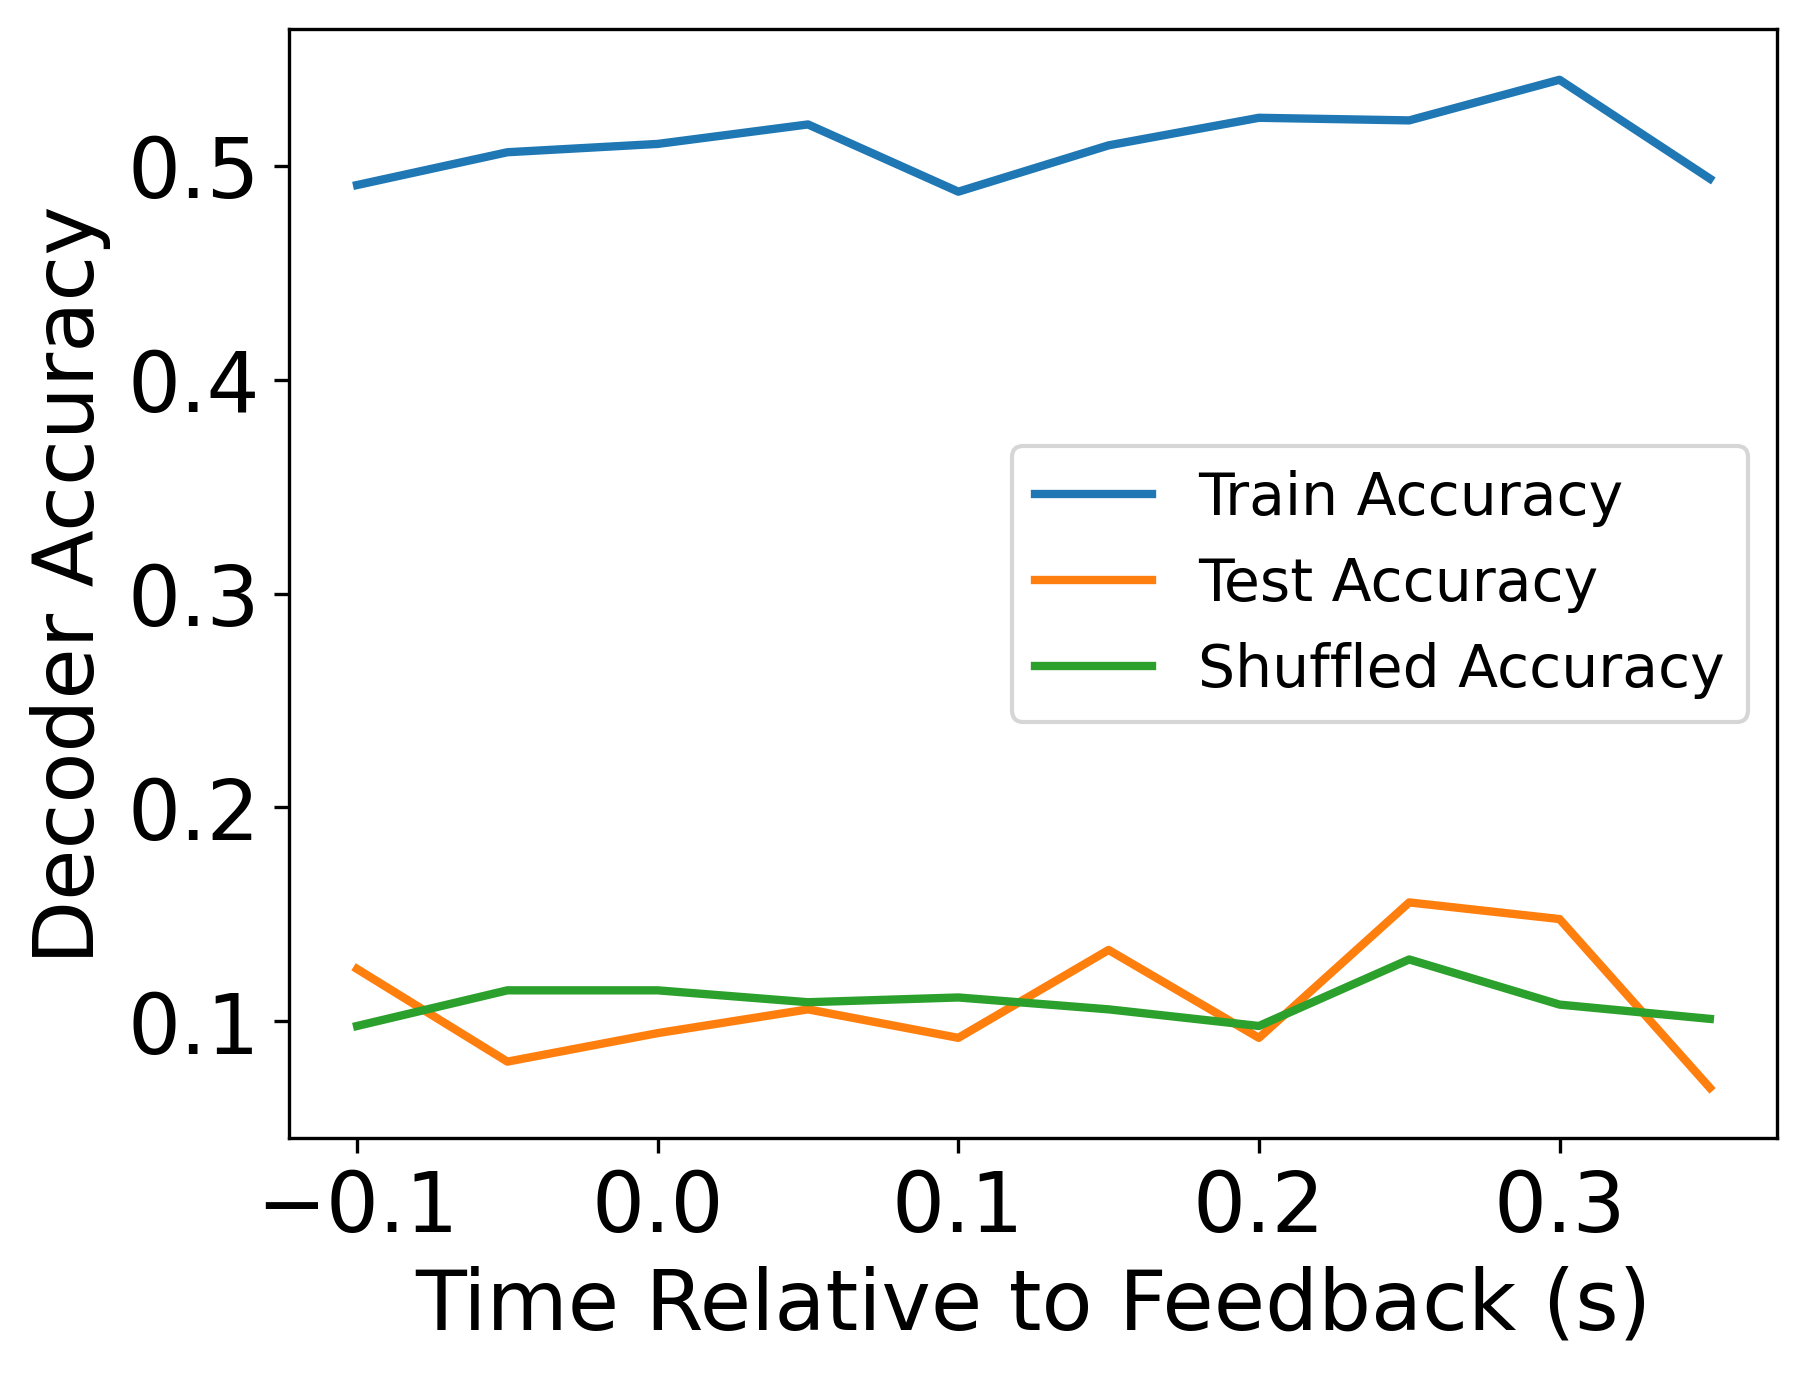

In [55]:
train_acc, test_acc, shuffled_acc, _, _ = io_utils.load_model_outputs(
    "test_pseudo_rule_decoding", 
    f"{pre_interval}_crossfixation_{post_interval}",
    "block_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    train_acc,
    0.15, 0.35, 0.05,
    ax,
    label="Train Accuracy",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_acc,
    0.15, 0.35, 0.05,
    ax,
    label="Test Accuracy",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_acc,
    0.15, 0.35, 0.05,
    ax,
    label="Shuffled Accuracy",
    right_align=True, 
    # color='black'
)

# ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})